In [35]:
import os
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, hstack, vstack
from pathlib import Path
from scipy.interpolate import interp1d

from cxotime import CxoTime

from kalman_watch import monitor_win_perigee as mwp, kalman_perigee_mon

import logging
mwp.logger.setLevel(logging.ERROR)
kalman_perigee_mon.LOGGER.setLevel(logging.ERROR)

In [36]:
SKA = Path(os.environ["SKA"])

In [37]:

def get_kalman_data(
    start,
    stop,
):
    ir_thresholds_start="2023:100"
    ir_thresholds_stop="2023:200"
    cache=True
    if (SKA/ "www" / "ASPECT" / "kalman_watch3").exists():
        data_dir = SKA / "www" / "ASPECT" / "kalman_watch3"
    else:
        data_dir = Path(".")

    # Intervals of NMAN within 100 minutes of perigee
    manvrs_perigee = mwp.get_manvrs_perigee(start, stop)

    # Get list of monitor window data for each perigee maneuver
    mons = []
    for manvr in manvrs_perigee:
        try:
            mon = mwp.get_mon_dataset(
                manvr["datestart"],
                manvr["datestop"],
                ir_thresholds_start,
                ir_thresholds_stop,
                data_dir,
                cache=cache,
            )
            mons.append(mon)
        except mwp.NotEnoughImagesError as err:
            pass

    # Process monitor window (NMAN) data into kalman drops per minute for each maneuver.
    # This uses idx to assign a different color to each maneuver (in practice each
    # perigee).
    kalman_drops_nman_list = [mwp.get_kalman_drops_nman(mon) for mon in mons]

    # Process NPNT data for the entire time range into kalman drops per minute. This
    # assigns different colors to each perigee.
    kalman_drops_npnt_list = mwp.get_kalman_drops_npnt(start, stop)

    def table_from_perigee(perigee):
        table = Table()
        perigee_time = CxoTime(perigee.perigee_date).cxcsec
        table["rel_time"] = perigee.times
        table["kalman_drops"] = perigee.kalman_drops
        # start and stop are the ranges used to get the data. Not useful.
        # table["start"] = perigee.start.date
        # table["stop"] = perigee.stop.date
        table["perigee"] = perigee.perigee_date
        table["perigee_cxcsec"] = perigee_time
        # why does the following give a different (and wrong) result?
        # table["cxcsec2"] = perigee_time + perigee.times
        table["cxcsec"] = table["perigee_cxcsec"] + perigee.times
        return table

    kalman_drops_nman_list =  vstack([table_from_perigee(perigee) for perigee in kalman_drops_nman_list if len(perigee.times) > 0])
    kalman_drops_npnt_list = vstack([table_from_perigee(perigee) for perigee in kalman_drops_npnt_list if len(perigee.times) > 0])

    kalman_drops_nman_list["type"] = 0
    kalman_drops_npnt_list["type"] = 1

    data = vstack([kalman_drops_npnt_list, kalman_drops_nman_list])

    # this assigns a unique ID to each perigee
    sorted_times = np.sort(np.unique(CxoTime(data["perigee"]).cxcsec))
    idx = np.searchsorted(sorted_times, CxoTime(data["perigee"]).cxcsec)
    assert np.unique(idx).shape == sorted_times.shape
    data["perigee_idx"] = idx

    return data


In [38]:
def interpolate(cxcsec, src):
    cols = [col for col in src.colnames if col != "cxcsec"]
    dest = Table()
    dest["cxcsec"] = cxcsec
    for col in cols:
        f = interp1d(src["cxcsec"], src[col], bounds_error=False, fill_value=np.nan)
        dest[col] = f(cxcsec)
    return dest

In [39]:
start = "2024:001"
stop = "2024:200"
kalman_data = get_kalman_data(start, stop)

In [40]:
perigee_times = CxoTime(np.unique(kalman_data["perigee"]))

In [41]:
rad_table = Table.read(
    SKA / "data" / "stk_radiation" / "rad_data_2022:003:12:00:00.000-2025:365:11:59:59.000.fits"
)
rad_table["time"] = CxoTime(rad_table["time"])
rad_table["cxcsec"] = rad_table["time"].cxcsec

r_cols = [col for col in rad_table.colnames if col[:7] == "proton_" or col == "cxcsec"] + ["mag_field"]
r = interpolate(kalman_data["cxcsec"], rad_table[r_cols])
data = hstack([
    kalman_data,
    r[[col for col in r.colnames if col != "cxcsec"]],
])
m = np.isnan(data["proton_81_300_MeV"])
# data = data[~m]

In [42]:
test_perigees = perigee_times[::3]  # one every three perigees is for checking
train_perigees = perigee_times.date[~np.in1d(perigee_times.date, test_perigees)]
test = data[np.in1d(data["perigee"], test_perigees)]
train = data[np.in1d(data["perigee"], train_perigees)]

## Choosing The Predictor Column

To predict the number of Kalman drops, we select the column with smallest mean square error after a linear regression.

In [43]:
def get_mse(col):
    # type 0 is NMAN, type 1 is NPNT
    sel = (train["type"] == 0) & ~np.isnan(train[col])
    t2 = train[sel]

    lr = scipy.stats.linregress(t2[col], t2["kalman_drops"])
    train_pred_kalman_drops = lr.intercept + lr.slope * t2[col]

    return np.mean((train_pred_kalman_drops - t2["kalman_drops"])**2)

In [44]:
columns = [col for col in train.colnames if col[:7] == "proton_"]
energy = [float(col[7:12].replace("_", ".")) for col in columns]

mse = [get_mse(col) for col in columns]

idx = np.argmin(mse)
min_mse, min_mse_energy = mse[idx], energy[idx]

Text(0.5, 1.0, 'MSE using a single predictor')

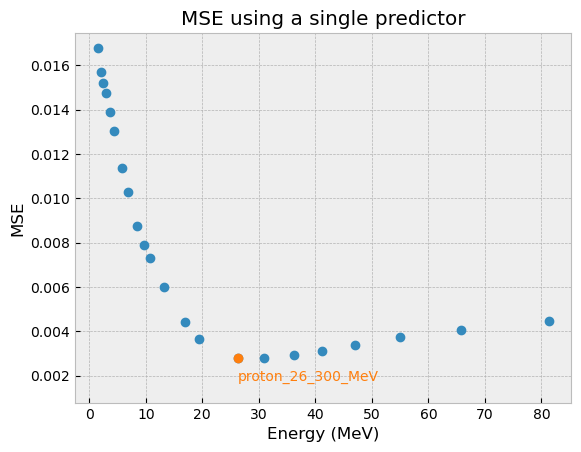

In [45]:
plt.plot(energy, mse, "o")
plt.plot(energy[idx], mse[idx], "o", color="tab:orange")
plt.xlabel("Energy (MeV)")
plt.ylabel("MSE")
plt.text(energy[idx], mse[idx] - 0.001, columns[idx], color="tab:orange")
plt.ylim(ymin=mse[idx] - 0.002)
plt.title("MSE using a single predictor")

We get the same column if we just maximize covariance

Text(0.5, 1.0, 'Covariance between IR fraction and proton flux')

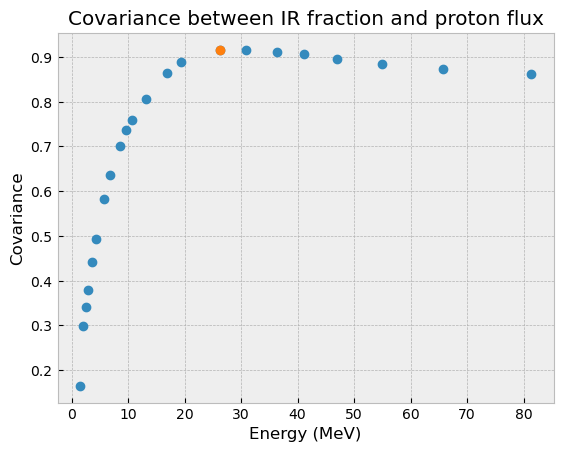

In [46]:
def get_cov(col):
    sel = (train["type"] == 0) & ~np.isnan(train[col])
    t2 = train[["kalman_drops", col]][sel].copy()
    for col in t2.colnames:
        t2[col] = (t2[col] - np.std(t2[col])) / np.std(t2[col])
    return np.cov(t2[col], t2["kalman_drops"])[0,1]

cov = [get_cov(col) for col in columns]

idx = np.argmax(cov)
max_cov, max_cov_energy = cov[idx], energy[idx]

plt.plot(energy, cov, "o")
plt.plot(energy[idx], cov[idx], "o", color="tab:orange")
plt.xlabel("Energy (MeV)")
plt.ylabel("Covariance")
plt.title("Covariance between IR fraction and proton flux")

In [47]:
columns[idx]

'proton_26_300_MeV'

## Linear Regression

In [48]:
predictor_col = "proton_26_300_MeV"

sel = (train["type"] == 0) & ~np.isnan(train[predictor_col])
lr = scipy.stats.linregress(train[predictor_col][sel], train["kalman_drops"][sel])

test["pred_kalman_drops"] = lr.intercept + lr.slope * test[predictor_col]
train["pred_kalman_drops"] = lr.intercept + lr.slope * train[predictor_col]

lr.intercept, lr.slope

(0.009539059218509838, 1.746916729296348e-09)

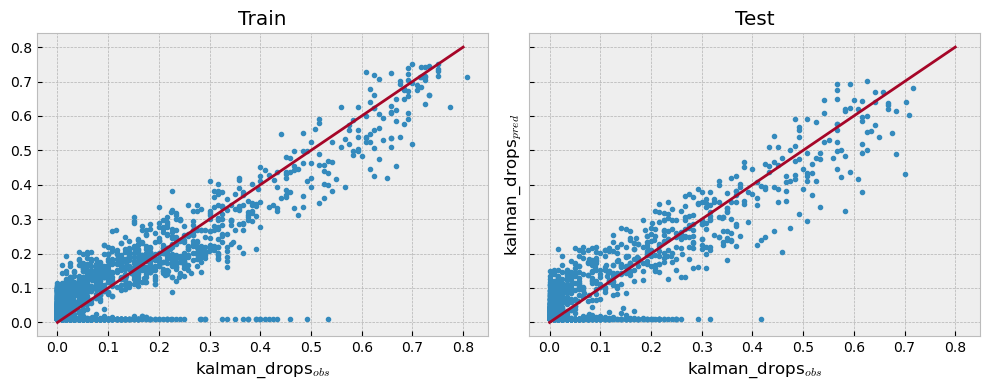

In [49]:
x = np.linspace(0, 0.8, 20)

fig, axes = plt.subplot_mosaic([["train", "test"]], figsize=(10, 4), sharex=True, sharey=True)
plt.sca(axes["train"])
plt.plot(
    train["kalman_drops"][train["type"] == 0],
    train["pred_kalman_drops"][train["type"] == 0],
    "."
)
plt.plot(x, x)
plt.title("Train")
plt.xlabel("kalman_drops$_{obs}$")

plt.sca(axes["test"])
plt.plot(
    test["kalman_drops"][test["type"] == 0],
    test["pred_kalman_drops"][test["type"] == 0],
    "."
)
plt.plot(x, x)
plt.title("Test")

plt.xlabel("kalman_drops$_{obs}$")
plt.ylabel("kalman_drops$_{pred}$")

plt.tight_layout()

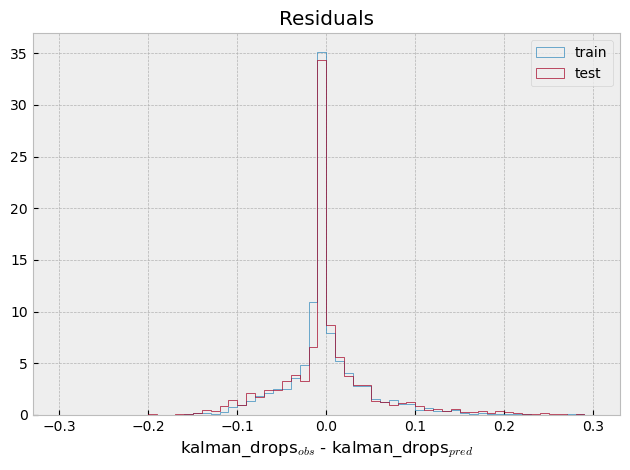

In [50]:
bins = np.linspace(-0.3, 0.3, 61)
plt.hist(
    train["kalman_drops"][train["type"] == 0] - train["pred_kalman_drops"][train["type"] == 0],
    bins=bins,
    histtype="step",
    density=True,
)
plt.hist(
    test["kalman_drops"][test["type"] == 0] - test["pred_kalman_drops"][test["type"] == 0],
    bins=bins,
    histtype="step",
    density=True,
)

plt.legend(["train", "test"])
plt.title("Residuals")
plt.xlabel("kalman_drops$_{obs}$ - kalman_drops$_{pred}$")
plt.tight_layout()

## Example Plot

In [53]:
def plot_one_perigee(
        perigee_time,
        draw_rad=False,
        draw_kalman_nman=False,
        rad_table_cols=[predictor_col],
        draw_rad_legend=None,
        draw_kalman_legend=None,
):
    fig = plt.figure(figsize=(10, 4))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    perigee_data = data[data["perigee"] == perigee_time]
    # there are two types of data: NPNT and NMAN. They might not be sorted by time.
    perigee_data.sort("rel_time")
    if draw_kalman_nman:
        draw_kalman_legend = draw_kalman_legend or (draw_kalman_legend is None and len(perigee_times) > 1)
        type_sel = perigee_data["type"] == 0
        plt.scatter(
            perigee_data["rel_time"][type_sel],
            perigee_data["kalman_drops"][type_sel],
            marker='o',
            label=perigee_time if draw_kalman_legend else None,
            # color=colors[p_idx % len(colors)]
        )
        type_sel = perigee_data["type"] == 1
        plt.scatter(
            perigee_data["rel_time"][type_sel],
            perigee_data["kalman_drops"][type_sel],
            marker='v',
            label=perigee_time if draw_kalman_legend else None,
            # color=colors[p_idx % len(colors)]
        )
    if draw_rad:
        draw_rad_legend = draw_rad_legend or (draw_rad_legend is None and len(rad_table_cols) > 1)

        for col_idx, col in enumerate(rad_table_cols):
            m = re.match("(?P<name>\S+)_(?P<e1>[0-9]+)_(?P<e2>[0-9])+_MeV", col)
            source = m.groupdict()
            source["name"] = {"proton": "p", "electron": "e"}[source["name"]]
            label = f"{source['name']} {source['e1']}.{source['e2']} MeV"

            # b, a = 1.72306678e-09, 0.011492516864638577
            a, b = lr.intercept, lr.slope
            sel = (rad_table["cxcsec"] > perigee_data["cxcsec"].min()) & (rad_table["cxcsec"] < perigee_data["cxcsec"].max())
            plt.plot(
                rad_table[sel]["cxcsec"] - perigee_data["perigee_cxcsec"][0],
                a + b * rad_table[sel][col],
                color="r",
                label=label if draw_rad_legend else None,
            )

    if draw_rad_legend or draw_kalman_legend:
        plt.legend()
    plt.xlabel("Time from perigee (minutes)")
    plt.ylabel("IR fraction")

    plt.tight_layout()

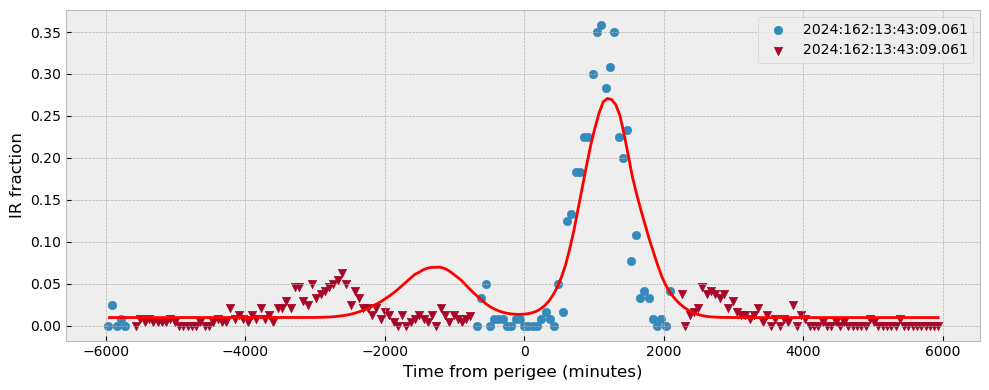

In [54]:
i = 60
plot_one_perigee(
    # "2024:003:22:01:14.988",
    perigee_times[i].date,
    draw_rad=True,
    draw_kalman_nman=True,
)